In [236]:
import pandas as pd
from category_encoders.one_hot import OneHotEncoder
from matplotlib import pyplot as plt
import numpy as np
import itertools

In [237]:
def process_age(df):
    # Temporarily fill na values with an absurd int
    df['age'].fillna(value= '200',inplace=True)

    # Get the index for all age values that are not numerics, then split those at "-" and store in temp series
    inx1 = ~ df['age'].apply(lambda x: x.isnumeric())
    temp = df.loc[inx1,'age'].str.split('-')

    # loop over splits, if single convert to str int, if 2 values then calculate midpoint.
    for inx2,ls in enumerate(temp):
        if len(ls) == 1:
            temp.iloc[inx2] = str(round(float(ls[0])))
        if len(ls) == 2:
            temp.iloc[inx2] = str(round(float(((int(ls[0]) + int(ls[1]))/2))))
    # replace the original age values with the processed values
    df.loc[inx1,'age'] = temp

    # Now deal with the NA values, replace with the group mean
    inx1 = df.loc[:,'age']=='200'
    df.loc[inx1,'age'] = str(int(df.loc[~inx1,'age'].astype(int).mean().round(0)))

    # Now replace strings with ints for better memory allocation
    df.loc[:,'age'] = df.loc[:,'age'].apply(int)
    
    df['age'] = np.log(df['age'])
    return df
# def process_age(df):
#     #calculate mean
#     ################need help with the floats###############
#     df1 = df[df['age']!='1.75']
#     index=df1['age'].str.find('-',0)
#     index=index<=0
#     mu=str(round(df1.loc[index,'age'].astype(int).mean(),0))

#     # fill na with the mean values
#     df['age'].fillna(value= mu,inplace=True)

#     # Get the index for all age values that are not numerics, then split those at "-" and store in temp series
#     inx1 = ~ df['age'].apply(lambda x: x.isnumeric())
#     temp = df.loc[inx1,'age'].str.split('-')
#     temp_max= df.loc[inx1,'age'].str.split('-')
#     temp_min= df.loc[inx1,'age'].str.split('-')
#     temp_range= df.loc[inx1,'age'].str.split('-')
#     # loop over splits:
#     # temp: mid point of the two values
#     # temp_max: higher value of two values
#     # temp_min: lower value of two values
#     # temp_range: if range value then = 1, else = 0

#     for inx2,ls in enumerate(temp):
#         if len(ls) == 1:
#             temp.iloc[inx2] = str(round(float(ls[0])))
#             temp_max.iloc[inx2]=str(round(float(ls[0])))
#             temp_min.iloc[inx2]=str(round(float(ls[0])))
#             temp_range.iloc[inx2]=0
#         if len(ls) == 2:
#             temp.iloc[inx2] = str(round(float(((int(ls[0]) + int(ls[1]))/2))))
#             temp_min.iloc[inx2] = str(round(float((int(ls[0])))))
#             temp_max.iloc[inx2] = str(round(float((int(ls[1]))))) 
#             temp_range.iloc[inx2]=1

#     #missing values
#     missing=df['age'].isnull().astype(int)

#     #create age_min, age_max, age_missing, age_range
#     df['age_min']=df['age']
#     df['age_max']=df['age']
#     df['age_missing'] = missing
#     df['age_range'] = 0

#     df.loc[inx1,'age'] = temp
#     df.loc[inx1,'age_min'] = temp_min
#     df.loc[inx1,'age_max'] = temp_max
#     df.loc[inx1,'age_range'] = temp_range
    
#     df.loc[:,['age']] = df['age'].apply(int)
#     df.loc[:,['age_min']] = df['age_min'].apply(int)
#     df.loc[:,['age_max']] = df['age_max'].apply(int)
#     df.loc[:,['age_range']] = df['age_range'].apply(int)


#     return df

def process_symptoms(df):
    # takes symptoms column and seperates each symptom into its own column

    # replace NaN with Asymptomatic
    df['symptoms'].fillna('Asymptomatic',inplace=True)

    #split symptoms on ";"
    splits = df['symptoms'].str.split(';').values

    # extract array into list of list
    listOfLists = [split for split in splits]

    # Get unique list of all symptoms 
    symptoms = list(set(list(itertools.chain.from_iterable(listOfLists))))

    # create array of zeros for one hot encoding
    holder = np.zeros((len(df),len(symptoms)))

    # Go through dataframe and record individual symptoms
    for inx,person in enumerate(df['symptoms']):
        symptoms_ls = person.split(';')
        for symptom in symptoms_ls:
            ls_index = symptoms.index(symptom)
            holder[inx,ls_index] = 1

    temp_df = pd.DataFrame(data = holder, columns = symptoms)
    # Add temp_df to main df
    df = pd.concat([df, temp_df],axis=1)

    # Drop the old symptoms column (commented for now to bug-check)
    df.drop('symptoms', inplace=True, axis=1)

    return df
def symptom_combiner(df, symptoms_to_combine, master_list, newcol_name):
    '''
    Combines passed symptoms into a single column named accordingly
    Assumes that the symptoms have been one hot encoded previously
    '''
    list_intersect = list(set(symptoms_to_combine) & set(master_list))
    temp_df = df.loc[:,list_intersect]
    temp_df['sum'] = temp_df.sum(axis=1)

    sum_col= (temp_df['sum'] >=1).apply(int)

    df.drop(list_intersect, inplace=True, axis=1)
    df[newcol_name] = sum_col

    return df

def encode_symtoms(df, train = True):
    if train:
        master_symp_list = [' sputum', ' conjunctivitis', ' runny nose',
       ' shortness of breath', 'low fever 37.0 ℃', ' weak', 'myalgia',
       'pneumonia', ' rhinorrhea', ' sore throat', 'low fever (37.2 ° C)',
       'physical discomfort', ' shortness breath', 'sore throat', 'discomfort',
       'severe dyspnea', 'pneumonitis', 'chest distress', ' expectoration',
       ' cough', ' malaise', ' nasal congestion', 'chest pain', 'headache',
       ' sneeze', 'dry cough', ' severe pneumonia', ' myalgia', ' headache',
       'fever (39.5 ℃)', 'diarrhea', ' dry mouth', 'muscular soreness',
       ' muscle ache', 'fever 37.7℃', ' muscular soreness', 'Asymptomatic',
       'systemic weakness', 'chills', 'fatigue', ' respiratory symptoms',
       ' weakness', ' nausea', 'nausea', ' vomiting', ' throat discomfort',
       ' muscular stiffness', 'poor physical condition', ' fatigue',
       'Pharyngeal dryness', 'respiratory symptoms', 'fever',
       'fever (38-39 ° C)', 'acute pharyngitis', ' fever', ' diarrhoea',
       'Sore throat', 'cough', ' diarrheoa']
    else:
        master_symp_list = [' runny nose', ' shortness of breath', ' weak', 'pharynx',
           ' sore throat', 'chest tightness', 'pneumonia', ' other symptoms',
           ' fever (38-39 ℃)', ' discomfort', ' fever (37 ℃)', 'sore throat',
           ' dry cough', 'fever 38.3', ' nasal congestion', ' pneumonia',
           'pneumonitis', ' cough', ' expectoration', ' sneezing', 'anhelation',
           'flu-like symptoms', ' sore body', ' myalgia', ' high fever',
           ' headache', ' toothache', ' dizziness', 'weakness', ' rhinorrhoea',
           ' dry mouth', 'diarrhea', 'pharyngeal discomfort', ' general malaise',
           ' muscular soreness', ' difficulty breathing', 'fever 37.7℃',
           ' pleuritic chest pain', 'Asymptomatic', 'feeling ill', ' cold',
           ' joint pain', ' pleural effusion', 'chills', 'fatigue', ' weakness',
           ' respiratory symptoms', ' nausea', ' coughing', 'abdominal pain',
           ' soreness', ' throat discomfort', ' dyspnea', 'nausea', 'malaise',
           ' fatigue', 'respiratory symptoms', 'anorexia', 'fever',
           ' pharyngeal discomfort', ' dry throat', ' fever', 'dry throat',
           'cough', ' diarrhea', 'low fever (37.4 ℃)']
        
#     process fever
    symptoms_to_combine = [' fever','fever (38-39 ° C)','low fever 37.0 ℃','fever 37.7℃','fever (39.5 ℃)',
                           'low fever (37.2 ° C)','fever', ' fever (38-39 ℃)',' fever (37 ℃)',
                           'fever 38.3',' high fever','low fever (37.4 ℃)','fever']
    newcol_name = 'fever'
    df = symptom_combiner(df, symptoms_to_combine, master_symp_list, newcol_name )
    
    # Malaise
    symptoms_to_combine = [' general malaise','malaise',' malaise']
    newcol_name = 'malaise'
    df = symptom_combiner(df, symptoms_to_combine, master_symp_list, newcol_name )
    
    # Weakness
    symptoms_to_combine = [' weak','weakness',' weakness','systemic weakness']
    newcol_name = 'weakness'
    df = symptom_combiner(df, symptoms_to_combine, master_symp_list, newcol_name )
    
    #Chest pains
    symptoms_to_combine = ['chest tightness',' pleuritic chest pain','chest distress','chest pain']
    newcol_name = 'chest pains'
    df = symptom_combiner(df, symptoms_to_combine, master_symp_list, newcol_name )
    
    # Throat problems
    symptoms_to_combine = ['pharynx',' sore throat','sore throat','pharyngeal discomfort','throat discomfort',
                          ' pharyngeal discomfort',' dry throat','dry throat',' throat discomfort','Sore throat',
                          'Pharyngeal dryness','acute pharyngitis']
    newcol_name = 'throat problems'
    
    df = symptom_combiner(df, symptoms_to_combine, master_symp_list, newcol_name )
    
    # Pneumonia
    symptoms_to_combine = ['pneumonia',' pneumonia','pneumonitis',' severe pneumonia']
    newcol_name = 'pneumonia'
    df = symptom_combiner(df, symptoms_to_combine, master_symp_list, newcol_name )
    
    # Coughs
    symptoms_to_combine = [' dry cough',' cough',' coughing','cough','dry cough'] + ['respiratory symptoms',' respiratory symptoms']
    newcol_name = 'coughs'
    df = symptom_combiner(df, symptoms_to_combine, master_symp_list, newcol_name )
    
    # Muscle pain
    symptoms_to_combine = ['anhelation',' muscular soreness',' soreness', ' myalgia','myalgia','muscular soreness',
                          ' muscle ache',' muscular stiffness']
    newcol_name = 'muscle pain'
    df = symptom_combiner(df, symptoms_to_combine, master_symp_list, newcol_name )
    
    # Nausea
    symptoms_to_combine = [' nausea','nausea']
    newcol_name = 'nausea'
    df = symptom_combiner(df, symptoms_to_combine, master_symp_list, newcol_name )
    
    # Shortness of breath
    symptoms_to_combine = [' shortness of breath',' difficulty breathing',' dyspnea',' shortness breath','severe dyspnea']
    newcol_name = 'shortness/difficulty breathing'
    df = symptom_combiner(df, symptoms_to_combine, master_symp_list, newcol_name )
    
    # Diarrhea
    symptoms_to_combine = [' diarrhea',' diarrhoea',' diarrheoa','diarrhea']
    newcol_name = 'diarrhea'
    df = symptom_combiner(df, symptoms_to_combine, master_symp_list, newcol_name )
    
    # respiratory symptoms
#     symptoms_to_combine = ['respiratory symptoms',' respiratory symptoms']
#     newcol_name = 'respiratory symptoms'
#     df = symptom_combiner(df, symptoms_to_combine, master_symp_list, newcol_name )
    
    
    # discomfort
    symptoms_to_combine = ['discomfort',' discomfort','physical discomfort'] + ['headache',' headache']
    newcol_name = 'discomfort'
    df = symptom_combiner(df, symptoms_to_combine, master_symp_list, newcol_name )
   
    # headache
#     symptoms_to_combine = ['headache',' headache']
#     newcol_name = 'headache'
#     df = symptom_combiner(df, symptoms_to_combine, master_symp_list, newcol_name )
    
    # fatigue
    symptoms_to_combine = ['fatigue',' fatigue']
    newcol_name = 'fatigue'
    df = symptom_combiner(df, symptoms_to_combine, master_symp_list, newcol_name )
    
    # cold/chills
    symptoms_to_combine = [' cold','feeling ill','chills','flu-like symptoms']
    newcol_name = 'cold/chills'
    df = symptom_combiner(df, symptoms_to_combine, master_symp_list, newcol_name )
    
   
    return df



In [238]:
train = pd.read_csv(r'train2.txt')
train.columns

Index(['age', 'sex', 'city', 'province', 'country', 'V1', 'confirmed',
       'symptoms', 'outcome', 'duration'],
      dtype='object')

In [239]:
test = pd.read_csv(r'test2.txt')
train = pd.read_csv(r'train2.txt')

# Extract the feature cols
feature_cols = ['age','sex','country','province','V1','symptoms','duration']

train = train.loc[:, feature_cols]
# Process age feature
train = process_age(train)
# Process symptoms
train = process_symptoms(train)
# encode symptoms
train = encode_symtoms(train, train=True)

feature_cols.remove('duration') 
feature_cols = feature_cols + ['Id']
test = test.loc[:, feature_cols]
# Process age feature
test = process_age(test)
# Process symptoms
test = process_symptoms(test)
# encode symptoms
test = encode_symtoms(test, train=False)

# Change test index to ID
test.set_index('Id',drop=True,inplace=True)

# remove outliers
inx = train['duration'] < 25
train = train.loc[inx,:]

# extract y from train
y = train.pop('duration')
# Adjust train and test to have same columns
trainColsToAdd = list(set(test.columns).difference(set(train.columns)))
train[trainColsToAdd] = 0

testColsToAdd = list(set(train.columns).difference(set(test.columns)))
test[testColsToAdd] = 0

ohe = OneHotEncoder()
train = ohe.fit_transform(train)
test = ohe.transform(test)
combined = np.concatenate((train.values,test.values))

C:\Users\justi\anaconda3\envs\stat440m1\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## processing is complete
at this point we have train and test datasets initialized to their desired format, now we can generate our k-fold CV sets from our training data and start training

In [106]:
cols_to_drop = ['sex_3','sex_4','sex_5','country_2','country_4', 'country_5','country_7', 'country_8',
       'country_9', 'country_10', 'country_11', 'country_12','province_1','province_9', 'province_10',
       'province_11', 'province_12', 'province_13', 'province_14',
       'province_15', 'province_16', 'province_17', 'province_18',
       'province_19', 'province_20', 'province_21', 'province_22',
       'province_23', 'province_24', 'province_25', 'province_26',
       'province_27', 'province_28', 'province_29', 'province_30',
       'province_31', 'province_32', 'province_33', 'province_34',
       'province_35', 'province_36', 'province_37', 'province_38',
       'province_39', 'province_40','V1_4','V1_5',
       'V1_6', 'V1_7', 'V1_8', 'V1_9', 'V1_10', 'V1_11','poor physical condition',
       ' vomiting', ' sputum', ' conjunctivitis', ' rhinorrhea', ' sneeze',' other symptoms',
       ' pleural effusion', 'abdominal pain', 'anorexia', ' dizziness',
       ' sneezing', ' joint pain', ' sore body', ' rhinorrhoea',
       ' toothache','diarrhea','muscle pain', 'nausea',
       'shortness/difficulty breathing', 'discomfort', 'fatigue',' dry mouth',
       ' expectoration', ' runny nose', ' nasal congestion','malaise', 'weakness', 'chest pains','cold/chills',
               'pneumonia','throat problems']
train.drop(cols_to_drop,axis=1,inplace=True)
test.drop(cols_to_drop, axis=1 , inplace=True)

In [107]:
train.columns.shape

(19,)

In [108]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

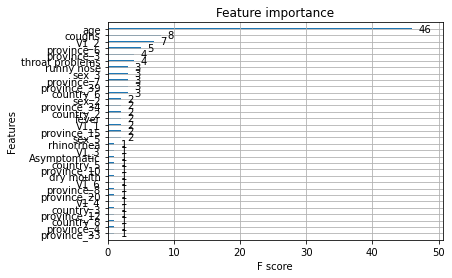

In [242]:
param = {}
kf = KFold(n_splits = 5, random_state=1, shuffle=True)
validated_rmses = []
test_preds = []


dtrain = xgb.DMatrix(train, label = y, feature_names = train.columns)
bst = xgb.train(param, dtrain, num_boost_round=5)

xgb.plot_importance(bst)

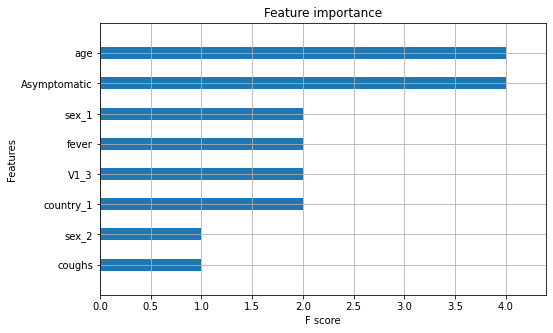

In [274]:
param = {'objective':'reg:squarederror','eta':0.5,'gamma':6, 'max_depth':9, 'min_child_weight':40, 'max_delta_step':2, 'subsample':1, 'lambda':0.5, 'alpha': 5}

dtrain = xgb.DMatrix(train, label = y, feature_names = train.columns)
bst = xgb.train(param, dtrain, num_boost_round=10)

fig,ax = plt.subplots(1,figsize=[8,5])
xgb.plot_importance(bst,ax=ax,show_values = False,height = 0.4)
plt.savefig('feature_importance.pdf',bbox_inches='tight')


<Figure size 432x288 with 0 Axes>

In [56]:
kf = KFold(n_splits = 5, random_state=1, shuffle=True)
linreg = LinearRegression()
rmses = []
test_preds = []


for train_inx,val_inx in kf.split(train):
    xTrain = train.values[train_inx]
    yTrain = y.values[train_inx]
    xVal = train.values[val_inx]
    yVal = y.values[val_inx]

    linreg.fit(xTrain,yTrain)
    yPred = linreg.predict(xVal) 
    rmse = np.sqrt(mean_squared_error(yVal,yPred))
    rmses.append(rmse)
    
    
    test_pred = linreg.predict(test)
    test_preds.append(test_pred)
print("cross_val RMSE = %s" % (sum(rmses)/len(rmses)))
test_preds = np.array(test_preds)
test_pred = test_preds.mean(axis=0)

cross_val RMSE = 4.047018156931779


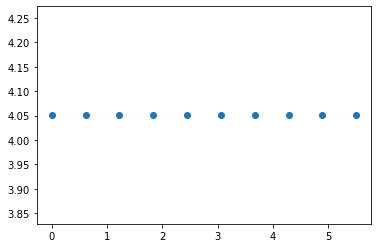

In [232]:
import xgboost as xgb
gammas = np.linspace(0,5.5,10)

param_rmses = []

for gamma in gammas:
    param = {'objective':'reg:squarederror','eta':0.5,'gamma':10, 'max_depth':9, 'min_child_weight':40, 'max_delta_step':2, 'subsample':1, 'lambda':0.5, 'alpha': 5}
    kf = KFold(n_splits = 5, random_state=1, shuffle=True)
    validated_rmses = []
    for train_inx, val_inx in kf.split(train):
        xTrain = train.iloc[train_inx]
        yTrain = y.values[train_inx]
        xVal = train.iloc[val_inx]
        yVal = y.values[val_inx]

        dtrain = xgb.DMatrix(xTrain, label = yTrain, feature_names = xTrain.columns)
        bst = xgb.train(param, dtrain, num_boost_round=5)

        dval = xgb.DMatrix(xVal, label= yVal, feature_names= xVal.columns)
        yPred = bst.predict(dval)
        validated_rmses.append(np.sqrt(mean_squared_error(yVal,yPred)))


    param_rmses.append(np.array(validated_rmses).mean())

plt.plot(gammas,param_rmses,'o')

In [233]:
param = {'objective':'reg:squarederror','eta':0.5,'gamma':6, 'max_depth':9, 'min_child_weight':40, 'max_delta_step':2, 'subsample':1, 'lambda':0.5, 'alpha': 5}
kf = KFold(n_splits = 5, random_state=1, shuffle=True)
validated_rmses = []
test_preds = []


dtrain = xgb.DMatrix(train, label = y, feature_names = train.columns)
bst = xgb.train(param, dtrain, num_boost_round=5)

dtest = xgb.DMatrix(test)
test_pred = bst.predict(dtest)


In [57]:
kf = KFold(n_splits = 5, random_state=1, shuffle=True)
linreg = RandomForestRegressor(n_estimators=75,max_samples=20, random_state=1,n_jobs=6)


rmses = []
test_preds = []


for train_inx,val_inx in kf.split(train):
    xTrain = train.values[train_inx]
    yTrain = y.values[train_inx]
    xVal = train.values[val_inx]
    yVal = y.values[val_inx]

    linreg.fit(xTrain,yTrain)
    yPred = linreg.predict(xVal) 
    rmse = np.sqrt(mean_squared_error(yVal,yPred))
    rmses.append(rmse)
    
    
    test_pred = linreg.predict(test)
    test_preds.append(test_pred)
print("cross_val RMSE = %s" % (sum(rmses)/len(rmses)))
test_preds = np.array(test_preds)
test_pred = test_preds.mean(axis=0)

cross_val RMSE = 4.022514286672876


In [ ]:
# residual plots
from yellowbrick.regressor.residuals import residuals_plot

residuals_plot(model= linreg,X_train=xTrain, y_train=yTrain, X_test= xVal, y_test=yVal , is_fitted=True)


In [ ]:
inx = (test_pred < 0)
test_pred[inx] = 0

In [234]:
sub = pd.DataFrame(test_pred, columns = ['duration'])
sub.index.rename('Id',inplace=True)
sub.index +=1

sub.describe()

,duration
count,200.000000
mean,3.954330
std,0.941347
min,2.356867
25%,3.502370
50%,4.100851
75%,4.500000
max,5.500000


In [235]:
sub.to_csv('kaggle_submission.txt')

In [224]:
sub.to_csv('justin_xgboost_1_pred.txt')